In [1]:
import sys
sys.path.append('/home/greg/GitHub/')
import pyEDIutils.changes as edi
import pandas as pd
import numpy as np

In [5]:
# Request changes from Dec 2021 to ...
new = edi.request_changes('2021-06-02', '2021-11-13')

Requesting PASTA changes for knb-lter-jrn from 2021-06-02 to 2021-11-13
https://pasta.lternet.edu/package/changes/eml?fromDate=2021-06-02&toDate=2021-11-13&scope=knb-lter-jrn
0 duplicate records were removed.


In [6]:
old = edi.archived_changes()

Reading archived PASTA request knb-lter-jrn_20150417-20181231.xml
Reading archived PASTA request knb-lter-jrn_20190101-20191231.xml
Reading archived PASTA request knb-lter-jrn_20200101-20200601.xml
Reading archived PASTA request knb-lter-jrn_20200602-20201201.xml
Reading archived PASTA request knb-lter-jrn_20201202-20210601.xml
9 duplicate records were removed.


In [7]:
max(old.date)

'2021-05-05T15:46:06.9'

In [8]:
df = pd.concat([old, new])
df

,date,pkgid,action
0,2015-04-17T14:42:05.936,2100011003,createDataPackage
1,2015-04-17T15:43:26.172,210120002,createDataPackage
2,2015-04-17T15:43:26.771,2100392001,createDataPackage
3,2015-04-17T15:43:41.508,2100169002,createDataPackage
4,2015-04-17T15:43:45.55,2100010001,createDataPackage
...,...,...,...
904,2021-11-12T18:59:15.867,210548009,updateDataPackage
905,2021-11-12T19:00:36.572,210548039,updateDataPackage
906,2021-11-12T19:08:48.071,210548069,updateDataPackage
907,2021-11-12T19:11:25.008,210548084,updateDataPackage


In [9]:
df = edi.get_counts(df)

In [10]:
daily = edi.counts_to_daily(df, startdt='2020-12-01')
daily

,n_update,n_create,n_tot
date,,,
2020-12-07,0,1,1
2020-12-08,0,0,0
2020-12-09,102,0,0
2020-12-10,1,0,0
2020-12-11,0,0,0
...,...,...,...
2021-11-08,0,0,0
2021-11-09,0,1,1
2021-11-10,0,0,0


## Plot activity since last report (2020-12-01)


In [17]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

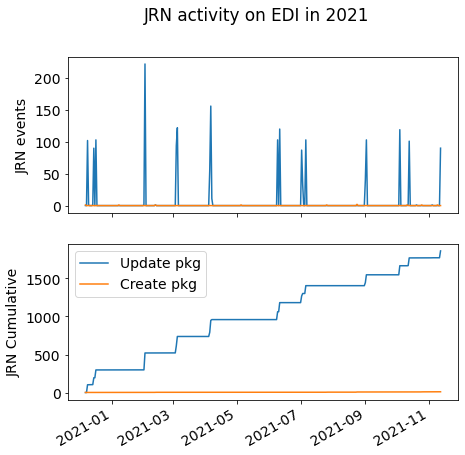

In [18]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update, label='Update pkg')
ax[0].plot(daily.index, daily.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily.index, daily.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily.index, daily.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily.index, daily.n_tot.cumsum(), label='Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI in 2021')
plt.legend()

import os
fig.savefig(os.path.expanduser("~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_2021_ann_rpt_{0}.png".format(now)),
            dpi=150, bbox_inches='tight',facecolor='w')

### Total number of packages

In [19]:
daily.n_create.sum()

10

In [20]:
daily.n_update.sum()

1862

## Plot 2021 activity excluding Met

In [22]:
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
daily_nomet = edi.counts_to_daily(df.loc[nomet], startdt='2020-12-01')

daily_nomet.head()

,n_update,n_create,n_tot
date,,,
2020-12-07,0,1,1
2020-12-08,0,0,0
2020-12-09,0,0,0
2020-12-10,0,0,0
2020-12-11,0,0,0


### Total number of packages

In [23]:
daily_nomet.n_create.sum()

10

In [24]:
daily_nomet.n_update.sum()

6

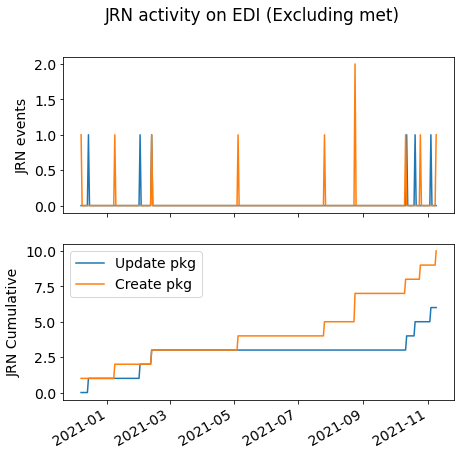

In [25]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_nomet.index, daily_nomet.n_update, label='Update pkg')
ax[0].plot(daily_nomet.index, daily_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_nomet.index, daily_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (Excluding met)')
plt.legend()

#fig.savefig(os.path.expanduser(
#    "/Users/gmaurer/GD_gmaurer.jrn.lter/IM/figures/JRN_EDI_2021_ann_rpt_NoMet_{0}.png".format(now)),
#            dpi=150, bbox_inches='tight',facecolor='w')

## Summary since last Annual Report

In [30]:
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
0,2015-04-17T14:42:05.936,2100011003,createDataPackage,0,1,0,1,011
1,2015-04-17T15:43:26.172,210120002,createDataPackage,0,1,0,1,120
2,2015-04-17T15:43:26.771,2100392001,createDataPackage,0,1,0,1,392
3,2015-04-17T15:43:41.508,2100169002,createDataPackage,0,1,0,1,169
4,2015-04-17T15:43:45.55,2100010001,createDataPackage,0,1,0,1,010


In [31]:
# Unique packages updated (excluding met)
rEDI = df.loc[df.date > '2020-12-01',]
rEDI_nomet = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.studyid!='548'),:]
print(len(rEDI.loc[rEDI.action=='updateDataPackage',]))
uniqueUp = rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp_nomet = rEDI_nomet.loc[rEDI_nomet.action=='updateDataPackage',].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
print(uniqueUp)
print(uniqueUp_nomet)
print(len(uniqueUp))
len(uniqueUp_nomet)

1862
[210437046 210437076 210437033 210437018 210437079 210437094 210437082
 210437097 210437083 210437098 210437084 210437099 210437085 210437100
 210437011 210437042 210437027 210437088 210437109 210437113 210437114
 210437115 210437001 210437031 210437016 210437091 210437002 210437032
 210437017 210437047 210437077 210437092 210437003 210437048 210437078
 210437093 210437004 210437034 210437019 210437049 210437005 210437020
 210437050 210437080 210437095 210437006 210437036 210437021 210437081
 210437096 210437007 210437037 210437022 210437052 210437008 210437038
 210437023 210437053 210437009 210437039 210437024 210437054 210437010
 210437040 210437025 210437055 210437041 210437026 210437056 210437086
 210437101 210437012 210437057 210437087 210437102 210437013 210437043
 210437028 210437058 210437103 210437014 210437044 210437029 210437059
 210437089 210437104 210437015 210437045 210437030 210437060 210437090
 210437105 210437107 210437108 210437110 210437111 210437112 210437116
 

5

In [34]:
pkgtbl = pd.DataFrame({'Total':[daily.n_create.sum(), daily.n_update.sum(),len(uniqueUp)],
                       'Non-Met':[daily_nomet.n_create.sum(), daily_nomet.n_update.sum(),len(uniqueUp_nomet)]})
pkgtbl.index = ['New packages created', 'Package updates', 'Unique package updates']

pkgtbl
#with open('tables_out/2021_annrpt_edi.md', 'w') as f:
#    f.write(pkgtbl.to_markdown(tablefmt="grid"))

,Total,Non-Met
New packages created,10,10
Package updates,1862,6
Unique package updates,228,5


In [35]:
uniqueUp2 = ['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=' + str(s)
             for s in uniqueUp]
with open('2021AR_unique_EDI_updates.txt', 'w') as f:
    for item in uniqueUp2:
        f.write("%s\n" % item)
        
uniqueUp2


['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437046',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437076',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437033',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437018',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437079',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437094',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437082',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437097',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437083',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437098',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437084',

In [ ]:
accessrpt